In [132]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

## Load data

In [2]:
df = pd.read_csv("../../data/sparkrecipes_base.csv")[["recipe_id", "title", "total_calories", "url", "servings"]]

In [3]:
df.head()

,recipe_id,title,total_calories,url,servings
0,5,20-Minute Chicken Creole,269.3,https://recipes.sparkpeople.com/recipe-detail....,1.0
1,3,Caribbean Black Beans and Rice,479.6,https://recipes.sparkpeople.com/recipe-detail....,NaN
2,6,Beef and Vegetable Stir-Fry,245.5,https://recipes.sparkpeople.com/recipe-detail....,NaN
3,7,Italian Vegetable Bake,37.2,https://recipes.sparkpeople.com/recipe-detail....,NaN
4,8,Carrot-Raisin Bread,100.1,https://recipes.sparkpeople.com/recipe-detail....,NaN


### Drop NA

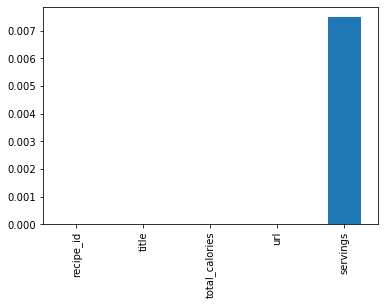

In [4]:
df.isna().mean().plot.bar()

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(63071, 5)

In [7]:
df.describe()

,recipe_id,total_calories,servings
count,63071.000000,63071.000000,63071.000000
mean,117969.269236,231.377982,8.174311
std,66271.902949,140.633320,10.157424
min,5.000000,0.000000,1.000000
25%,62764.500000,129.900000,4.000000
50%,118090.000000,206.800000,6.000000
75%,176385.000000,305.600000,10.000000
max,230141.000000,999.900000,255.000000


### Drop recipes for sauces

In [62]:
sauce_mask = df.title.str.lower().str.contains("sauce")

df[sauce_mask].sample(10)

,recipe_id,title,total_calories,url,servings
33219,122646,Mock Hollandaise Sauce,30.0,https://recipes.sparkpeople.com/recipe-detail....,6.0
1939,4712,Home Made Spaghetti Sauce,131.0,https://recipes.sparkpeople.com/recipe-detail....,6.0
27857,103715,"Reuben sauce, lo cal, world's best",44.1,https://recipes.sparkpeople.com/recipe-detail....,10.0
55659,202972,Spicy Korean BBQ Marinade & Sauce,91.7,https://recipes.sparkpeople.com/recipe-detail....,4.0
44600,165330,'Get Yer Green In' Pasta Sauce w/ Veggies and ...,197.8,https://recipes.sparkpeople.com/recipe-detail....,11.0
47852,176854,Chunky veggie & tofu Spagetti Sauce,182.9,https://recipes.sparkpeople.com/recipe-detail....,6.0
49727,183447,Jam PAsta Sauce 4 0z serving,189.7,https://recipes.sparkpeople.com/recipe-detail....,4.0
9278,35019,Spaghetti Sauce,203.4,https://recipes.sparkpeople.com/recipe-detail....,10.0
50569,186381,Laura's Spaghetti (Cook sauce all day),448.7,https://recipes.sparkpeople.com/recipe-detail....,1.0
47507,175558,Cafe Con Leche Sauce,156.7,https://recipes.sparkpeople.com/recipe-detail....,15.0


In [39]:
df_no_sauce = df[~sauce_mask]

### Drop recipes with too many / too few servings

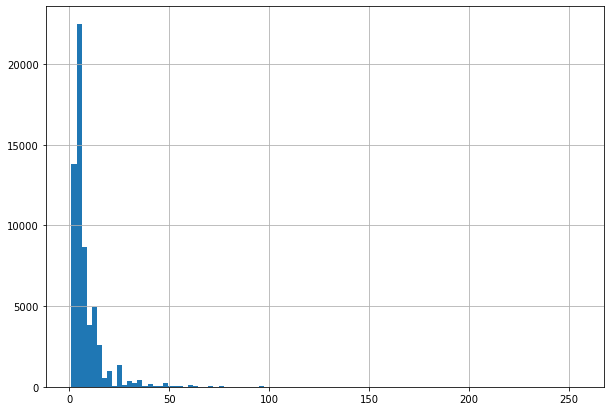

In [40]:
df_no_sauce.servings.hist(bins=100, figsize=(10, 7))

In [41]:
servings_top_quantile = df_no_sauce.servings.quantile(0.95)

f"Top Q: {servings_top_quantile}"

'Top Q: 24.0'

Here we exclude recipes with the number of servings greater than 1.0 because it's likely that the user simply forgot to add this information.

In [42]:
df_filtered_serv = df_no_sauce[(df_no_sauce.servings > 1.0) * (df_no_sauce.servings < servings_top_quantile)]
df_filtered_serv.sample(10)

,recipe_id,title,total_calories,url,servings
211,257,Chocolate Cinnamon Bread Pudding,422.8,https://recipes.sparkpeople.com/recipe-detail....,6.0
26834,100281,"Turkey, beans, and salsa",360.1,https://recipes.sparkpeople.com/recipe-detail....,6.0
36558,134854,Teriyaki Pork Kabobs,256.9,https://recipes.sparkpeople.com/recipe-detail....,4.0
34099,125719,chocolate chip cheesecake,312.5,https://recipes.sparkpeople.com/recipe-detail....,16.0
11602,45408,Black Bean and Corn Salsa,136.1,https://recipes.sparkpeople.com/recipe-detail....,4.0
35855,132101,All Natural Ground Turkey Spaghetti,255.4,https://recipes.sparkpeople.com/recipe-detail....,10.0
15225,59761,Slow Cooker Pulled BBQ Beef,381.4,https://recipes.sparkpeople.com/recipe-detail....,8.0
44879,166407,Rikki's Apple Pie,219.8,https://recipes.sparkpeople.com/recipe-detail....,12.0
50394,185827,Gluten-Free Cheeseburger Pie,184.6,https://recipes.sparkpeople.com/recipe-detail....,6.0
38749,143089,Shrimp and Spinach with Linguine,357.6,https://recipes.sparkpeople.com/recipe-detail....,4.0


In [43]:
df_filtered_serv.shape

(49533, 5)

### Drop Outliers w.r.t. total calories

In [72]:
top_quantile = df_filtered_serv.total_calories.quantile(0.97)
bottom_quantile = df_filtered_serv.total_calories.quantile(0.01)

f"Top Q: {top_quantile}, Bottom Q:  {bottom_quantile}"

'Top Q: 524.9, Bottom Q:  22.8'

In [73]:
df_filtered = df_filtered_serv[(df_filtered_serv.total_calories > bottom_quantile) * (df_filtered_serv.total_calories < top_quantile)]
df_filtered.shape

(47547, 5)

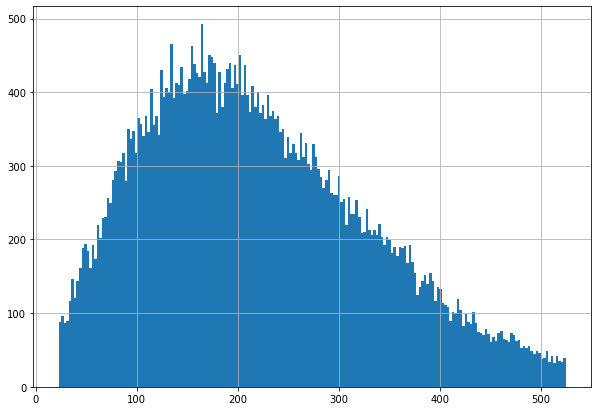

In [74]:
df_filtered.total_calories.hist(bins=200, figsize=(10, 7));

In [75]:
df_filtered.total_calories.describe()

count    47547.000000
mean       220.086683
std        109.747397
min         22.900000
25%        135.300000
50%        205.500000
75%        292.800000
max        524.800000
Name: total_calories, dtype: float64

In [76]:
df_dropouts = df.drop(df_filtered.index)

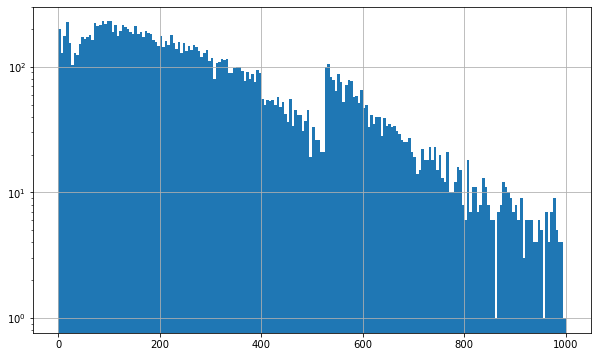

In [77]:
df_dropouts.total_calories.hist(bins=200, log=True, figsize=(10, 6));

In [78]:
with pd.option_context('display.max_rows', 10, 'max_colwidth', -1):
    display(df_dropouts[["title", "total_calories", "url"]].sample(10))

,title,total_calories,url
63363,Ham and Veggies in the slow cooker,455.3,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=229508
4950,Pumpkin Soup Recipe Problem,83.3,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=16337
63282,Turkey Meat Sauce for Pasta,202.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=229234
24186,Farmhouse Spaghetti,569.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=91352
63143,Lori's Chocolate Slimming Shake,169.8,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=228665
49399,Chicken and Stuffing,568.9,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=182375
43776,La Quesadilla con Champinion Buton y sin grasa,273.4,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=162267
35947,French Toast with Strawberries and Whipped Cream,266.1,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=132443
1385,Spicy Chicken Noodle,425.6,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=3036
60957,Homemade power bars,196.7,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=220528


In [79]:
df_dropouts.total_calories.describe()

count    15524.000000
mean       265.961041
std        204.643266
min          0.000000
25%        107.475000
50%        213.500000
75%        371.325000
max        999.900000
Name: total_calories, dtype: float64

### Analyze recipes with high / low calories

In [80]:
fil_top_quantile = df_filtered.total_calories.quantile(0.90)
fil_bottom_quantile = df_filtered.total_calories.quantile(0.1)

In [81]:
df_high_cal = df_filtered[df_filtered.total_calories > fil_top_quantile]
df_low_cal = df_filtered[df_filtered.total_calories < fil_bottom_quantile]

In [82]:
df_high_cal.shape

(4750, 5)

In [83]:
df_low_cal.shape

(4750, 5)

In [84]:
with pd.option_context('max_colwidth', -1):
    display(df_high_cal.sample(10))

,recipe_id,title,total_calories,url,servings
51995,191126,mom's mac and cheese with tomatoes,497.7,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=191126,6.0
46124,170765,Amy's Chicken Quesadillas,420.4,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=170765,4.0
2407,6098,taco hash,518.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=6098,3.0
55536,202577,Cream cheese and Sausage Stuffed Tomatos,486.0,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=202577,4.0
42953,159324,baked buffalo wings,383.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=159324,2.0
29560,109665,calzone,399.5,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=109665,6.0
63304,229311,Pizza Stuffed Potatos,449.6,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=229311,2.0
7714,28574,"Sarah""s Veggie Pasta",460.7,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=28574,8.0
43548,161419,Italian Marinated Chicken,404.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=161419,4.0
31564,116760,One Pot Saucy Meatball Pasta,424.5,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=116760,5.0


In [85]:
with pd.option_context('max_colwidth', -1):
    display(df_low_cal.sample(10))

,recipe_id,title,total_calories,url,servings
42184,156461,Monika's Special Cabbage,77.8,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=156461,4.0
33810,124740,Bissara,78.7,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=124740,6.0
17808,68723,Spring Roll Filling,85.4,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=68723,12.0
41543,153926,Melissa's Crustless Mini Quiches,44.3,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=153926,12.0
6361,22615,Southwest Tortilla filling,62.9,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=22615,4.0
28247,104961,Vanilla cupcakes,65.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=104961,12.0
2938,7952,Three Bean Salad,67.0,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=7952,12.0
37801,139598,Healthy Flax/OO Mayo,30.0,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=139598,16.0
4023,12375,Red Lentil Dal,77.3,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=12375,8.0
46708,172740,Sun Dried Tomato Dip,35.1,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=172740,16.0


In [86]:
high_cal_wc = WordCloud().generate(" ".join(df_high_cal.title.str.lower()))
low_cal_wc = WordCloud().generate(" ".join(df_low_cal.title.str.lower()))

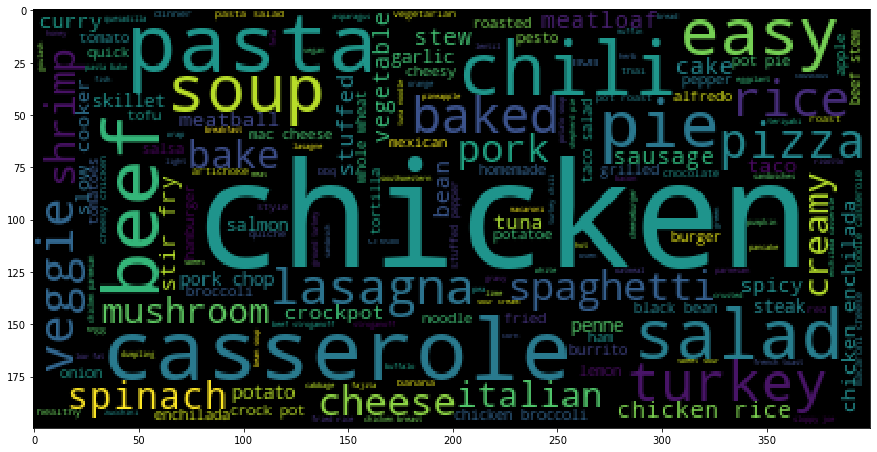

In [87]:
plt.figure(figsize = (15,15))
plt.imshow(high_cal_wc, interpolation='nearest')

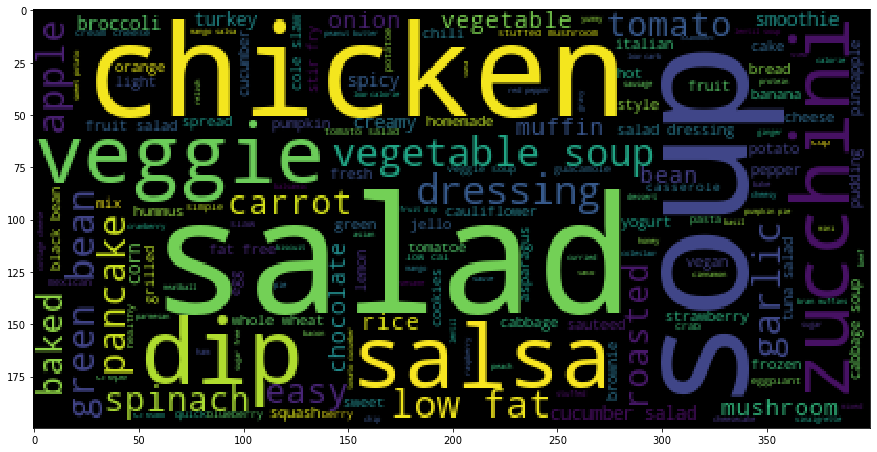

In [88]:
plt.figure(figsize = (15,15))
plt.imshow(low_cal_wc, interpolation='nearest')

## Create baseline model

In [128]:
PREDICT_MEAN_STRATEGY = lambda df_train: df_train["total_calories"].mean()
PREDICT_MEDIAN_STRATEGY = lambda df_train: df_train["total_calories"].median()

class BaselineModel(BaseEstimator, RegressorMixin):

    def __init__(self):
        pass
    
    def fit(self, _, y):
        self.mean_ = y.mean()
        return self
    
    def predict(self, X):
        check_is_fitted(self, [])
        
        return np.array(X.shape[0] * [self.mean_])

In [142]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered, df_filtered.total_calories, test_size=0.33, random_state=42)

In [154]:
model = BaselineModel().fit(X_train, y_train)
model.score(X_test, y_test)

-2.586318262709497e-05

In [155]:
y_pred = model.predict(X_test)

In [156]:
r2_score(y_test, y_pred)

-2.586318262709497e-05

In [157]:
explained_variance_score(y_test, y_pred)

0.0

In [158]:
max_error(y_test, y_pred)

304.5291687594173

In [159]:
mean_absolute_error(y_test, y_pred)

89.97539146428508

In [160]:
mean_squared_error(y_test, y_pred)

12039.572200832712

In [161]:
mean_squared_log_error(y_test, y_pred)

0.35583677186260837

In [162]:
median_absolute_error(y_test, y_pred)

80.17083124058263